In [1]:
!pip install pydicom

     |████████████████████████████████| 7.1MB 4.7MB/s 


In [0]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
from sklearn.model_selection import KFold

In [3]:


!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!python setup.py -q install

# Import Mask RCNN
sys.path.append('Mask_RCNN')  # To find local version of the library

from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN

import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time

from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model

%matplotlib inline

from os import listdir
from xml.etree import ElementTree



Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 32.57 MiB/s, done.
Resolving deltas: 100% (569/569), done.
zip_safe flag not set; analyzing archive contents...


Using TensorFlow backend.


In [0]:
!ls

assets	images	     mask_rcnn.egg-info  requirements.txt  setup.py
build	LICENSE      mrcnn		 samples
dist	MANIFEST.in  README.md		 setup.cfg


In [0]:
import zipfile
with zipfile.ZipFile("../BCCD_Dataset-master.zip", 'r') as zip_ref:
    zip_ref.extractall("")

In [0]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from imgaug import augmenters as iaa
from tqdm import tqdm_notebook
import numpy as np
import json
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes



%matplotlib inline

In [0]:
image_path = 'BCCD_Dataset-master/BCCD/JPEGImages/'
annot_path = 'BCCD_Dataset-master/BCCD/Annotations/'

all_imgs, seen_labels = parse_annotation(annot_path, image_path)



In [0]:
train = pd.DataFrame(columns=["image_names", "cell_type", "xmin", "xmax","ymin", "ymax"])

In [0]:
row_count = 0
for img in all_imgs:
  filename=img['filename']
  for cell in img[ 'object'] :
      bbdict = { "image_names" : filename , "cell_type" : cell['name'], "xmin" : cell['xmin'], "xmax": cell['xmax'],"ymin" : cell['ymin'], "ymax": cell['ymax']}
      train.loc[row_count] =bbdict
      row_count+=1


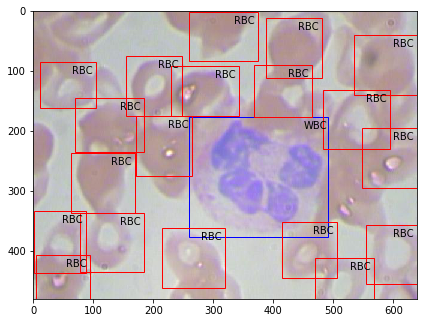

In [11]:
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
path=train['image_names'].values[0]
image = plt.imread(path)
plt.imshow(image)

for _,row in train[train.image_names == path].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    
    # assign different color to different classes of objects
    if row.cell_type == 'RBC':
        edgecolor = 'r'
        ax.annotate('RBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'WBC':
        edgecolor = 'b'
        ax.annotate('WBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'Platelets':
        edgecolor = 'g'
        ax.annotate('Platelets', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

In [12]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+3
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
os.mkdir("working")

In [14]:
train.head()

,image_names,cell_type,xmin,xmax,ymin,ymax
0,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,WBC,260,491,177,376
1,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,RBC,78,184,336,435
2,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,RBC,63,169,237,336
3,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,RBC,214,320,362,461
4,BCCD_Dataset-master/BCCD/JPEGImages/BloodImage...,RBC,414,506,352,445


In [0]:
class BCCDDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "RBC")
        self.add_class("dataset", 2,"WBC")
        self.add_class("dataset",3,"Platelets")
        
        # define data locations for images and annotations

        images_dir = 'BCCD_Dataset-master/BCCD/JPEGImages/'
        annotations_dir = 'BCCD_Dataset-master/BCCD/Annotations/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions

        for filename in dataset['image_names'].unique():

            image_id=filename.split('/')[-1].split('.')[-2].split("_")[-1]

            # skip all images after 150 if we are building the train set
            if is_train and int(image_id) < 50:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(image_id) >= 50:
                continue
            
            # setting image file
            img_path = filename
            
            # setting annotations file
            ann_path = annotations_dir + filename.split('/')[-1].split('.')[-2] + '.xml'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=int(image_id), path=img_path, annotation=img_path)

      

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        boxes=list()
        names=list()
        t=train[train['image_names']==filename].values
        for box in t :
            xmin = box[2]
            ymin = box[4]
            xmax = box[3]
            ymax = box[5]
            name = box[1]
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            names.append(name)
       
        
        # extract image dimensions
        image = plt.imread(path)
        
        width = image.shape[1]
        height = image.shape[0]
        return boxes, width, height,names

    # load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h,names = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(names[i]))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    #Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        path=info['path']
        image = plt.imread(path)
        return image

In [30]:
# prepare train set
train_set = BCCDDataset()
train_set.load_dataset(train, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = BCCDDataset()
test_set.load_dataset(train, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 316
Test: 48


In [0]:
image_id = random.choice(train_set.image_ids)

{'id': 160, 'source': 'dataset', 'path': 'BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00160.jpg', 'annotation': 'BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00160.jpg'}
(480, 640, 3)
BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00160.jpg
[1 1 1 1 1 1 1 1 1 3 2]


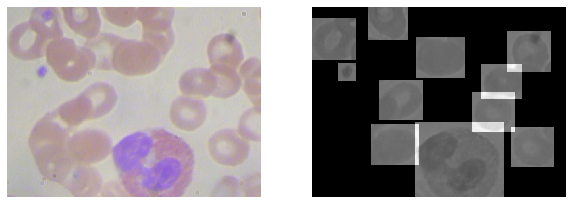

In [18]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(train_set.image_ids)
    image_fp = train_set.image_reference(image_id)
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [19]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [0]:
# initialize the Mask R-CNN model for inference 
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='working/')
#n load the weights for COCO
model.load_weights('mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


In [0]:
# train weights (output layers or 'heads')
## train heads with higher lr to speedup the learning
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE*2, epochs=2, layers='heads')

history = model.keras_model.history.history

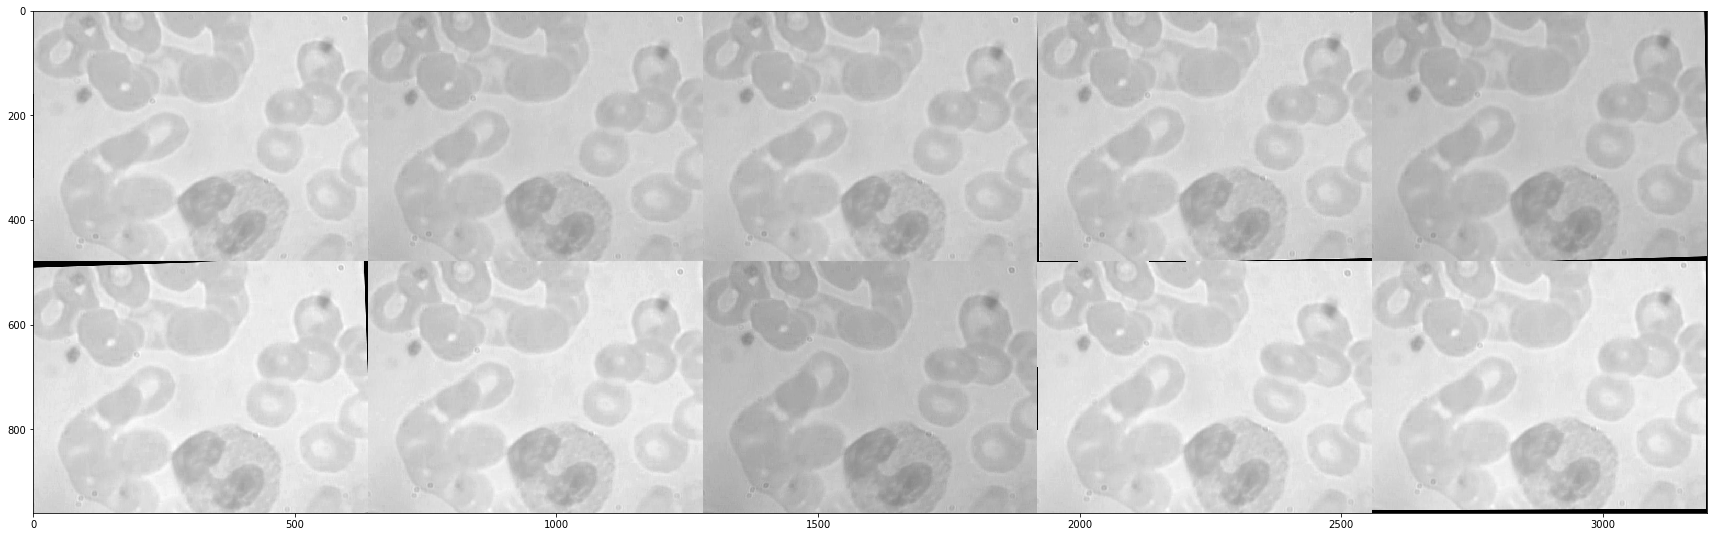

In [22]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [23]:
%%time
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE,
            epochs=6,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 3/6
131/131 [==============================] - 356s 3s/step - loss: 1.0553 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.2606 - mrcnn_class_loss: 0.3279 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.2445 - val_loss: 1.2925 - val_rpn_class_loss: 0.0428 - val_rpn_bbox_loss: 0.1940 - val_mrcnn_class_loss: 0.4884 - val_mrcnn_bbox_loss: 0.2570 - val_mrcnn_mask_loss: 0.3102
Epoch 4/6
131/131 [==============================] - 269s 2s/step - loss: 0.8117 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.2803 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2167 - val_loss: 1.2053 - val_rpn_class_loss: 0.0409 - val_rpn_bbox_loss: 0.2196 - val_mrcnn_class_loss: 0.4421 - val_mrcnn_bbox_loss: 0.2052 - val_mrcnn_mask_loss: 0.2975
Epoch 5/6
131/131 [==============================] - 301s 2s/step - loss: 0.7492 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1456 - mrcnn_class_loss: 0.2518 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.2182 - val_loss: 1.0888 - val_rpn_class_loss

In [0]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=16,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [0]:

model_path = 'mask_rcnn_'  + '.' + str(time.time()) + '.h5'
model.keras_model.save_weights(model_path)

In [0]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = pyplot.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='working/')

# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)



In [0]:
image_id = 10

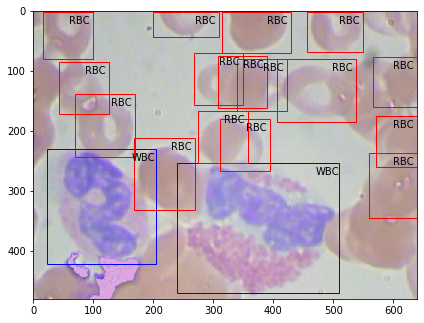

In [44]:
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
path=test_set.image_info[image_id]['path']
image = plt.imread(path)
plt.imshow(image)

for _,row in train[train.image_names == path].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    
    # assign different color to different classes of objects
    if row.cell_type == 'RBC':
        edgecolor = 'r'
        ax.annotate('RBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'WBC':
        edgecolor = 'b'
        ax.annotate('WBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'Platelets':
        edgecolor = 'g'
        ax.annotate('Platelets', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

{'id': 10, 'source': 'dataset', 'path': 'BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00010.jpg', 'annotation': 'BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00010.jpg'}
image ID: dataset.10 (10) BCCD_Dataset-master/BCCD/JPEGImages/BloodImage_00010.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


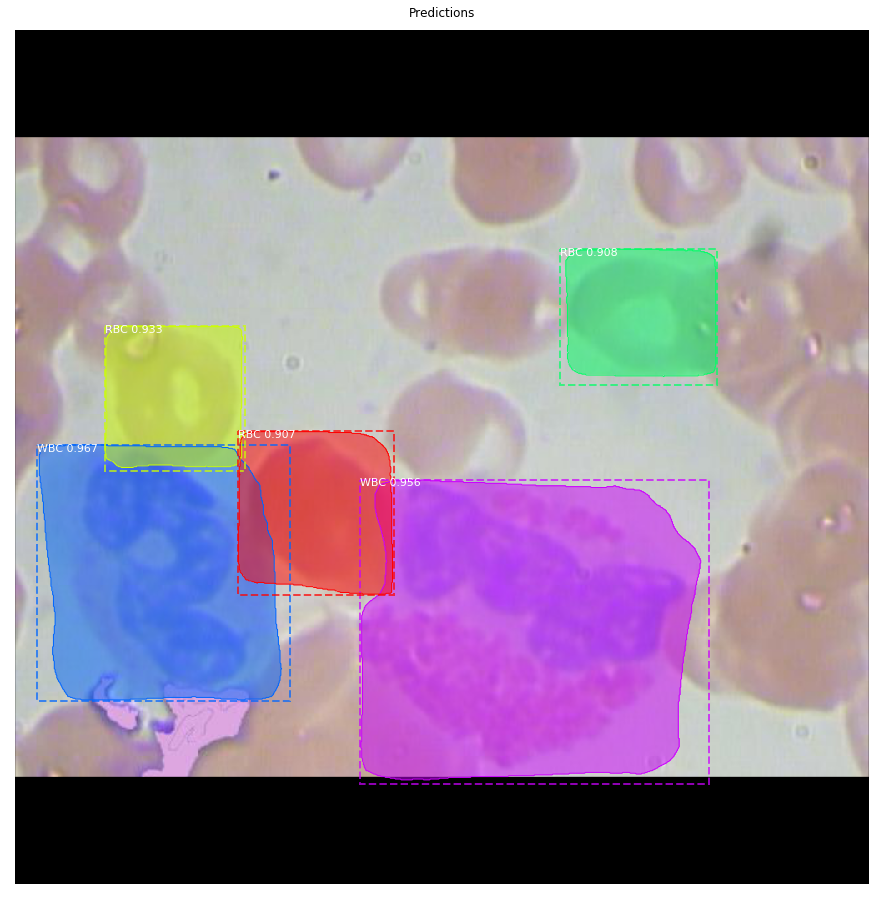

In [45]:
#image_id = random.choice(test_set.image_ids)


image, image_meta, gt_class_id, gt_bbox, gt_mask =   modellib.load_image_gt(test_set, config, image_id, use_mini_mask=False)
info = test_set.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       test_set.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'],
                            title="Predictions")